<a href="https://colab.research.google.com/github/WoradeeKongthong/stock_price_time_series/blob/master/05_stockPrice_multivariateMLP_multiStepOutput.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MLP : time series forcasting with n features input and multi-steps output**

In [0]:
import numpy as np
import pandas as pd
from pandas_datareader import data
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


# Dataset : google stock price (2015-2019) from yahoo.com

In [0]:
df = data.DataReader('GOOG', data_source='yahoo', start='2015-01-01', end='2019-12-31')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680


In [0]:
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-01-02,529.815369,522.665039,527.561584,523.373108,1447500.0,523.373108
2015-01-05,522.894409,511.655243,521.827332,512.463013,2059800.0,512.463013
2015-01-06,514.761719,499.678131,513.589966,500.585632,2899900.0,500.585632
2015-01-07,505.855164,498.281952,505.611847,499.727997,2065000.0,499.727997
2015-01-08,502.101471,489.655640,496.626526,501.303680,3353500.0,501.303680
...,...,...,...,...,...,...
2019-12-24,1350.260010,1342.780029,1348.500000,1343.560059,347500.0,1343.560059
2019-12-26,1361.327026,1344.469971,1346.170044,1360.400024,667500.0,1360.400024
2019-12-27,1364.530029,1349.310059,1362.989990,1351.890015,1038400.0,1351.890015


#  Get X from Dataframe
Time series to train the model is the 'Close' price.  

In [0]:
X1 = df.loc[:, ['Open']].values
X2 = df.loc[:, ['Close']].values

In [0]:
print('X1 shape : ',X1.shape)
print('X2 shape : ',X2.shape)

X1 shape :  (1258, 1)
X2 shape :  (1258, 1)


# Data Preprocessing

In [0]:
# Feature Scaling on the data
from sklearn.preprocessing import MinMaxScaler
sc1 = MinMaxScaler(feature_range = (0,1))
sc2 = MinMaxScaler(feature_range = (0,1))

X1 = sc1.fit_transform(X1)
X2 = sc2.fit_transform(X2)
data_scaled = np.concatenate((X1, X2), axis=1)

In [0]:
# check the shape of preprocessed data
print('data shape : ', data_scaled.shape)
data_scaled[:5]

data shape :  (1258, 2)


array([[0.03938367, 0.03698029],
       [0.03279298, 0.0244395 ],
       [0.02332534, 0.01078684],
       [0.01415566, 0.00980102],
       [0.00382835, 0.01161222]])

# Create timestep sequence
X : n_steps sequence of data  
y : 1 step output

In [0]:
def create_sequence(data, n_steps_in, n_steps_out):
  X = []
  y = []
  for i in range(n_steps_in, len(data)-n_steps_out+1):
    X.append(data[i - n_steps_in:i])
    y.append(data[i : i + n_steps_out, 1])
  return np.array(X), np.array(y)

In [0]:
# choose number of timesteps
n_steps_in = 60
n_steps_out = 3
# Create the sequence and the output
X,y = create_sequence(data_scaled, n_steps_in, n_steps_out)
print('X shape : ',X.shape)
print('y shape : ',y.shape)

# MLP model need X and y dimensions to be [samples, timesteps]
# X dimension will be [samples, timesteps * features]
n_input = X.shape[1]*X.shape[2]
X = X.reshape(X.shape[0],n_input)
y = y.reshape(y.shape[0],y.shape[1])  
print('after reshape')
print('X shape : ',X.shape)
print('y shape : ',y.shape)

X shape :  (1196, 60, 2)
y shape :  (1196, 3)
after reshape
X shape :  (1196, 120)
y shape :  (1196, 3)


In [0]:
print(X[0], '==>', y[0])

[0.03698029 0.0244395  0.01078684 0.00980102 0.01161222 0.00414966
 0.         0.00416113 0.00953737 0.01059198 0.01780232 0.01644967
 0.02921971 0.04796196 0.05433553 0.04890201 0.02989603 0.02000327
 0.02075982 0.04811105 0.04118724 0.04205846 0.03463028 0.04015557
 0.04407599 0.04044216 0.05088509 0.04977316 0.05775158 0.06472121
 0.05764838 0.05404893 0.05768276 0.05318922 0.0451191  0.04991074
 0.05882914 0.07213788 0.07548511 0.09031852 0.09295505 0.09264552
 0.09489232 0.08612869 0.08746415 0.07159914 0.06720873 0.07217225
 0.06278394 0.07102595 0.06681893 0.07674606 0.07501512 0.07773192
 0.0759551  0.08900025 0.07592647 0.07178253 0.06395319 0.06818308] ==> [0.06356339 0.05732741 0.04926879]


# MLP model

In [0]:
from keras.models import Sequential
from keras.layers import Dense

Using TensorFlow backend.


In [0]:
# define MLP model
model = Sequential()
model.add(Dense(units=100, activation='relu', input_dim=n_input))
model.add(Dense(units=n_steps_out))
model.compile(optimizer='adam', loss='mse')

# Train MLP

In [0]:
history = model.fit(X, y, epochs = 1000, verbose = 0)

training loss :  0.06891055840587736


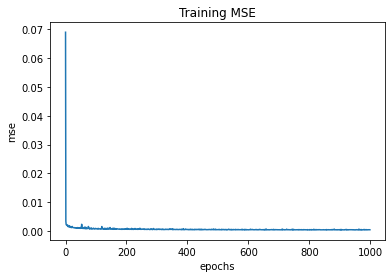

In [0]:
score = history.history['loss'][0]
print('training loss : ', score)

plt.plot(history.history['loss'])
plt.title('Training MSE')
plt.xlabel('epochs')
plt.ylabel('mse')
plt.show()

In [0]:
y_pred = model.predict(X)

# inverse transform the price
y = sc1.inverse_transform(y[:,0].reshape(len(y),1))
temp_list = []
for i in range(n_steps_out):
  temp = y_pred[:,i].reshape(len(y_pred),1)
  temp = sc1.inverse_transform(temp)
  temp_list.append(temp)
y_pred_inv = np.concatenate(temp_list, axis=1)

In [0]:
y_pred_inv.shape

(1196, 3)

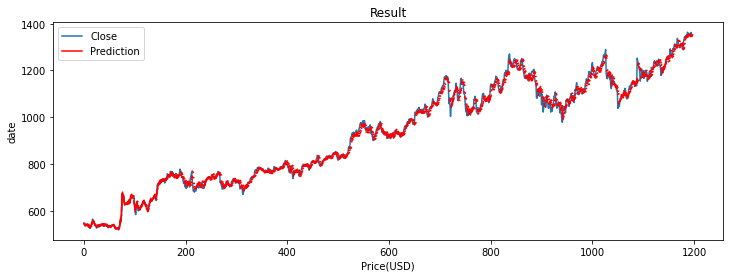

In [0]:
# plot the whole result
plt.figure(figsize=(12,4))
plt.plot(y)
for i in range(len(y_pred_inv)):
  plt.plot(np.arange(i, i+n_steps_out), y_pred_inv[i], c='red')
plt.title('Result')
plt.xlabel('Price(USD)')
plt.ylabel('date')
plt.legend(['Close', 'Prediction'])
plt.show()

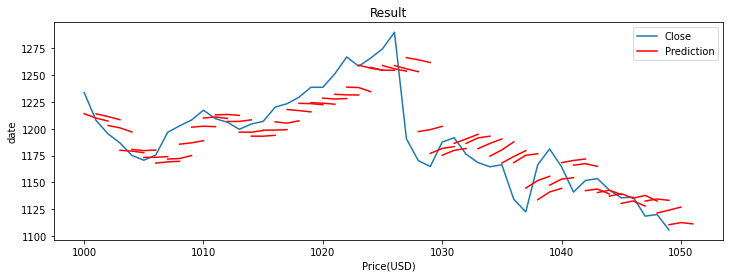

In [0]:
# plot the first 30 days of dataset
start_day = 1000
end_day = 1050

plt.figure(figsize=(12,4))
plt.plot(np.arange(start_day, end_day),y[start_day: end_day])
for i in range(start_day, end_day):
  plt.plot(np.arange(i, i+n_steps_out), y_pred_inv[i], c='red')
plt.title('Result')
plt.xlabel('Price(USD)')
plt.ylabel('date')
plt.legend(['Close', 'Prediction'])
plt.show()